<H1>Debugging Large Language Models (LLMs) with Captum</H1>

In this exercise we will use Captum's (captum.ai) LLM API to explore the reasoning capabilities of LLaMa2 models.

We will design prompts and test the model on continuation, classification, zero and few shot-learning tasks.

The following tutorial is good reference point for the excersises described in this notebook: https://captum.ai/tutorials/Llama2_LLM_Attribution


First, lets install all dependancies that will help us to execute our code.

In your python enviorment (e.g. conda) install pytorch-cuda (e.g.: `conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia`), captum, bytesandbits, transformers, huggingface accelerate.

Request access to LLaMa2 (https://llama.meta.com/llama-downloads/) if you haven't already done so.

You can use Hugging Face API to access model weights. If you choose that path, make sure that you're logged in into hugging face with `huggingface-cli`.

This exercise consists of three parts.

1. In the first part of this exercise we aim to understand how the model learns input and output associations for a continuation task.
This notebook contains example prompts and showcases how to use Captum with LLMs to explain those associations. You will be asked to write your own prompts and play with different configuration of the explainability API and prompt parametrization.

2. In the second part, we use LLM as a binary classifier. We will examine whether Chain or Thought classifier agrees with the attribution-based explanations and how robust those explanations are.

3. In the third part, we will examine the importance of few shot examples for a simple reasoning task.

In [1]:
import sys
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

from captum.attr import (
    FeatureAblation, 
    ShapleyValues,
    ShapleyValueSampling,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ProductBaselines,
)


In [2]:
# Let's make sure that CUDA is enabled
print('Is CUDA Enabled: ', torch.cuda.is_available())

Is CUDA Enabled:  True


Defining helper function to load the configs and the model.

In [3]:
def create_bnb_config():
    return BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )


def load_model_and_tokenizer(model_name, bnb_config=create_bnb_config()):
    n_gpus = torch.cuda.device_count()
    max_memory = "10000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

Let's load `Llama-3-13-chat-hf` model and the tokenizer associated with it.

In [4]:
model_name = "meta-llama/Llama-2-13b-chat-hf" 
# loading LlaMa2 Chat 13B
model, tokenizer = load_model_and_tokenizer(model_name)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/private/home/narine/.conda/envs/captum/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:769: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

Let's define attribution methods and corresponding LLM API wrappers. 

We will use attribution API wrapper classes in combination with different perturbation and gradient-based algorithms to compute sample-based attributions.


In [6]:
#Attribution methods
fa = FeatureAblation(model)
sv = ShapleyValues(model)

lig = LayerIntegratedGradients(model, model.model.embed_tokens)

# LLM API for feaature ablation
llm_attr_fa = LLMAttribution(fa, tokenizer)

# LLM API for shapely values
llm_attr_sc = LLMAttribution(sv, tokenizer)

# LLM API for gradient-based methods
llm_attr_grad = LLMGradientAttribution(lig, tokenizer)


<H2>Input-Output associations</H2>

Let's prompt LLM with a simple text that LLM will continue up to 20 tokens.

In [7]:
galileo_prompt = "Galileo was born in Pisa, Italy. He discovered"

input_tokenized = tokenizer(galileo_prompt, return_tensors="pt").to("cuda")

print('Tokenized Input: ', tokenizer.convert_ids_to_tokens(input_tokenized['input_ids'].detach().cpu().numpy()[0]))# 

with torch.no_grad():
    output_ids = model.generate(input_tokenized["input_ids"], max_new_tokens=20, temperature=0.1, do_sample=True)[0]
    output_tokenized = tokenizer.decode(output_ids, skip_special_tokens=True)
    print('LLM Response: ', output_tokenized)

Tokenized Input:  ['<s>', '▁Gal', 'ile', 'o', '▁was', '▁born', '▁in', '▁P', 'isa', ',', '▁Italy', '.', '▁He', '▁discovered']
LLM Response:  Galileo was born in Pisa, Italy. He discovered the four largest moons of Jupiter and observed the phases of Venus, which provided strong evidence


In order to pass the tokenizer, the prompt and other parameters to Captum we wrap those arguments in `TextTokenInput` class. We then call `attribute` on an attribution algorithm by passing our `TextTokenInput` object. The latter outputs token-level explanations for each input-output token pair. 

In [8]:
inp = TextTokenInput(
    galileo_prompt, 
    tokenizer,
    skip_tokens=[1],  # skip the special token for the start of the text <s>
)

attr_res = llm_attr_fa.attribute(inp, gen_args={"max_new_tokens": 20, "do_sample": True, "temperature": 0.1}) 
# we can also pass a concrete target as an output such as: llm_attr_pert.attribute(inp, target="four largest moons of Jupiter", ... )

attr_res

`plot_token_attr` is an example helper function to plot pair-wise attributions. Feel free to use your favorite visualisation tool for that.

Input tokens ['▁Gal', 'ile', 'o', '▁was', '▁born', '▁in', '▁P', 'isa', ',', '▁Italy', '.', '▁He', '▁discovered']
Output tokens ['▁the', '▁four', '▁largest', '▁mo', 'ons', '▁of', '▁Jup', 'iter', '▁and', '▁observed', '▁the', '▁phases', '▁of', '▁Ven', 'us', ',', '▁which', '▁provided', '▁strong', '▁evidence']


(<Figure size 1690x800 with 2 Axes>, <Axes: >)

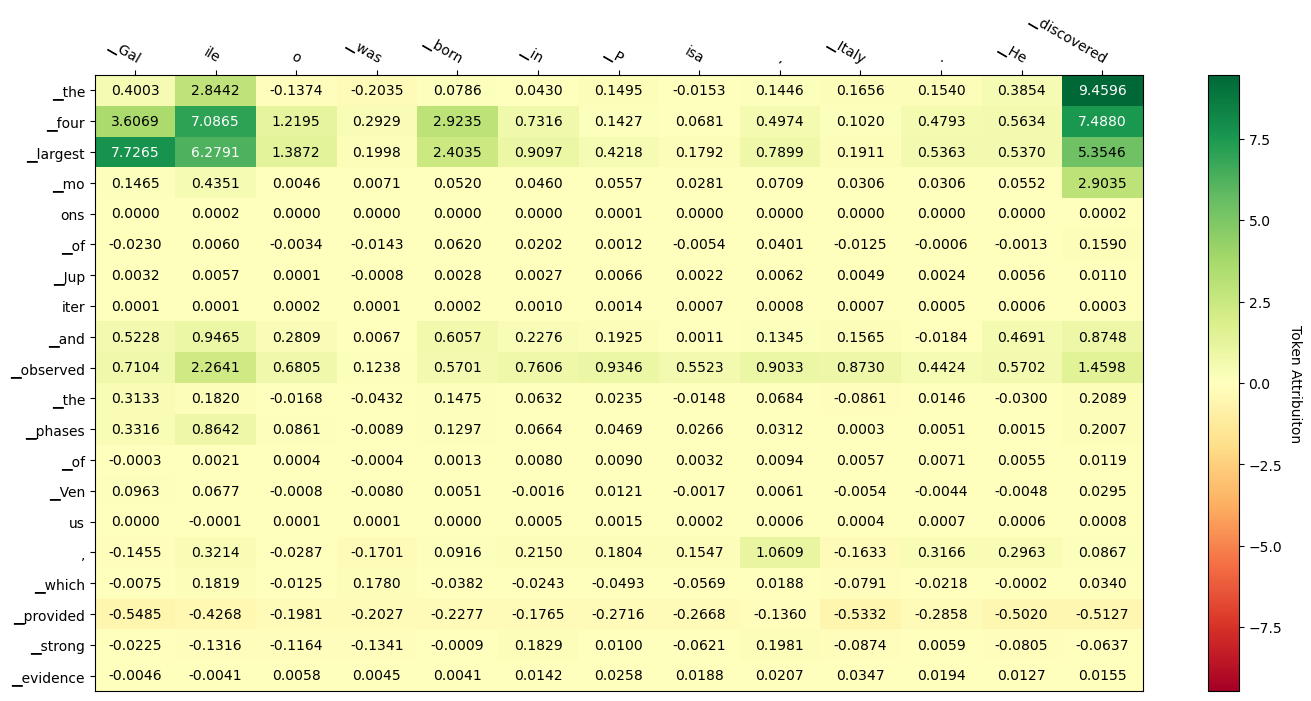

In [9]:
print('Input tokens', attr_res.input_tokens)
print('Output tokens', attr_res.output_tokens)
attr_res.plot_token_attr()

Now let's mask words together. `TextTemplateInput` helps us to parametrize the input and filter the attribution for specific input tokens.
This can be especially useful if the number of input and output tokens is relatively large.

In this example we look into the associations between specific input tokens `Galileo`, `Pisa, Italy` and each output sub-word. 

(<Figure size 640x800 with 2 Axes>, <Axes: >)

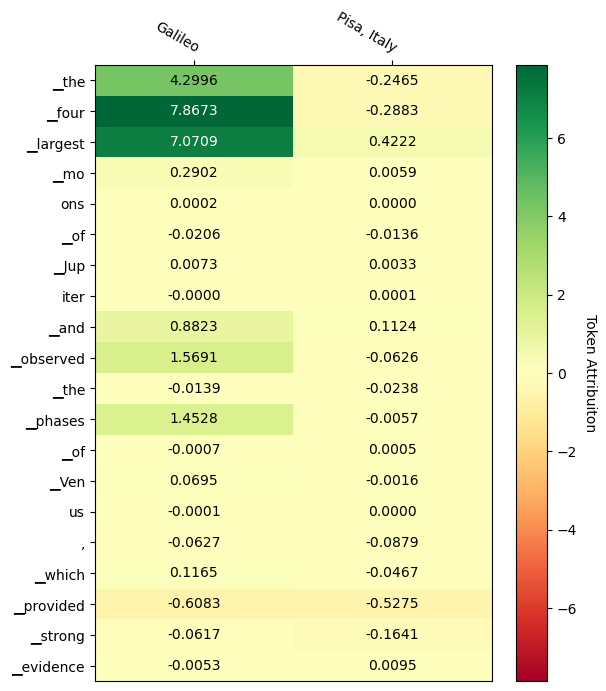

In [12]:
inp = TextTemplateInput(
    template="{} was born in {}. He discovered", 
    values=["Galileo", "Pisa, Italy"],
)
attr_res = llm_attr_fa.attribute(inp, gen_args={"max_new_tokens": 20, "do_sample": True, "temperature": 0.01}) 
attr_res.plot_token_attr()

The same example as before but here we use specific baselines.

(<Figure size 640x800 with 2 Axes>, <Axes: >)

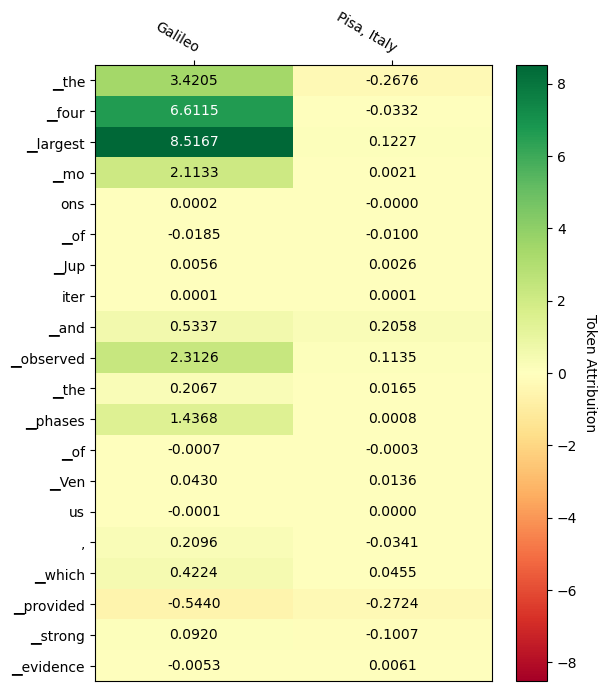

In [11]:
inp = TextTemplateInput(
    template="{} was born in {}. He discovered", 
    values=["Galileo", "Pisa, Italy"],
    baselines=["Unknown", "Unknown, Unknown"],
)
attr_res = llm_attr_fa.attribute(inp, gen_args={"max_new_tokens": 20, "do_sample": True, "temperature": 0.01}) 
attr_res.plot_token_attr()

Instead of specifying a specific baseline value we can specify a distribution of baselines. The attribution algorithm will sample uniformly random from that distribution
and average the results across multiple baselines for more rebust outcomes.

(<Figure size 640x800 with 2 Axes>, <Axes: >)

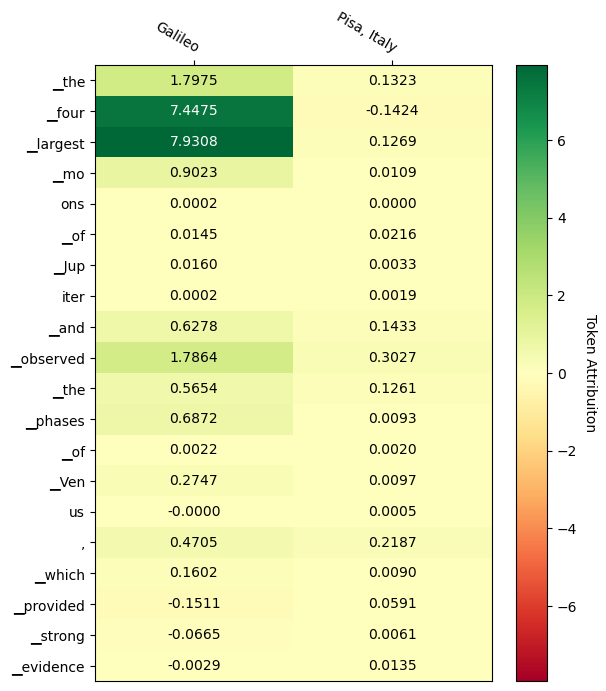

In [13]:
baselines = ProductBaselines(
    {
        "name":["James", "Alice", "Bob", "Sam", "Mary", "Eve", "Rob"],
        "location": ["New York, USA", "Muenich, Germany", "London, UK", "Amsterdam, Netherlands", 
                     "Koeln, Germany", "San Francisco, USA", "LA, USA"], 
    }
)

inp = TextTemplateInput(
    template="{name} was born in {location}. He discovered", 
    values={"name": "Galileo", "location": "Pisa, Italy"},
    baselines=baselines,
)
attr_res = llm_attr_fa.attribute(inp, gen_args={"max_new_tokens": 20, "do_sample": True, "temperature": 0.01}) 
attr_res.plot_token_attr()

<H2>Excercise 1</H2>

1. Define a continuation prompt of your choice.
2. Compute and compare attributions for perturbation and gradient-based methods.
3. Specify a target sequence that we want to attribute to, if the output is very long.
4. Use `TextTemplateInput` to group input subwords together.
5. Use masks to combine tokens in different parts of the input together.
6. Observe the impact of the baseline selection on the attribution results. Leverage `ProductBaselines` to sample from a distribution of baselines.

<H1>Classification<H1>

In this excercise we will use LLMs as a binary sentiment classifier. We will examine whether chain of thought agrees on key sentiment tokens with the attribution-based explanations.

Below is an example prompt which asks LLM to classify a movie review as `positive` or `negative` sentiment. In this examples chain of thought suggests that `aweful` is a key token associated with negative sentiment.

In [16]:
movie_rating_prompt = "Your goal is to classify movie rating reviews as `positive` or `negative` sentiment. Is given text positive or negative sentiment ? " \
                      "'An awful film! It must have been up against some real stinkers to be nominated for the Golden Globe.'"  \
                      "Answer simply: 'positive' or 'negative'. Think step by step"

input_tokenized = tokenizer(movie_rating_prompt, return_tensors="pt").to("cuda")

print('Tokenized input: ', tokenizer.convert_ids_to_tokens(input_tokenized['input_ids'].detach().cpu().numpy()[0]))# 

with torch.no_grad():
    output_ids = model.generate(input_tokenized["input_ids"], max_new_tokens=42, temperature=0.1, do_sample=True)[0]
    output_tokenized = tokenizer.decode(output_ids, skip_special_tokens=True)
    print('LLM Response: ', output_tokenized)

Tokenized input:  ['<s>', '▁Your', '▁goal', '▁is', '▁to', '▁class', 'ify', '▁movie', '▁rating', '▁reviews', '▁as', '▁`', 'pos', 'itive', '`', '▁or', '▁`', 'negative', '`', '▁sentiment', '.', '▁Is', '▁given', '▁text', '▁positive', '▁or', '▁negative', '▁sentiment', '▁?', "▁'", 'An', '▁awful', '▁film', '!', '▁It', '▁must', '▁have', '▁been', '▁up', '▁against', '▁some', '▁real', '▁st', 'ink', 'ers', '▁to', '▁be', '▁nominated', '▁for', '▁the', '▁Golden', '▁Glo', 'be', ".'", 'Answer', '▁simply', ':', "▁'", 'pos', 'itive', "'", '▁or', "▁'", 'negative', "'.", '▁Think', '▁step', '▁by', '▁step']
LLM Response:  Your goal is to classify movie rating reviews as `positive` or `negative` sentiment. Is given text positive or negative sentiment ? 'An awful film! It must have been up against some real stinkers to be nominated for the Golden Globe.'Answer simply: 'positive' or 'negative'. Think step by step, and consider the context of the text.

I would say that the sentiment of the given text is negativ

(<Figure size 2470x480 with 2 Axes>, <Axes: >)

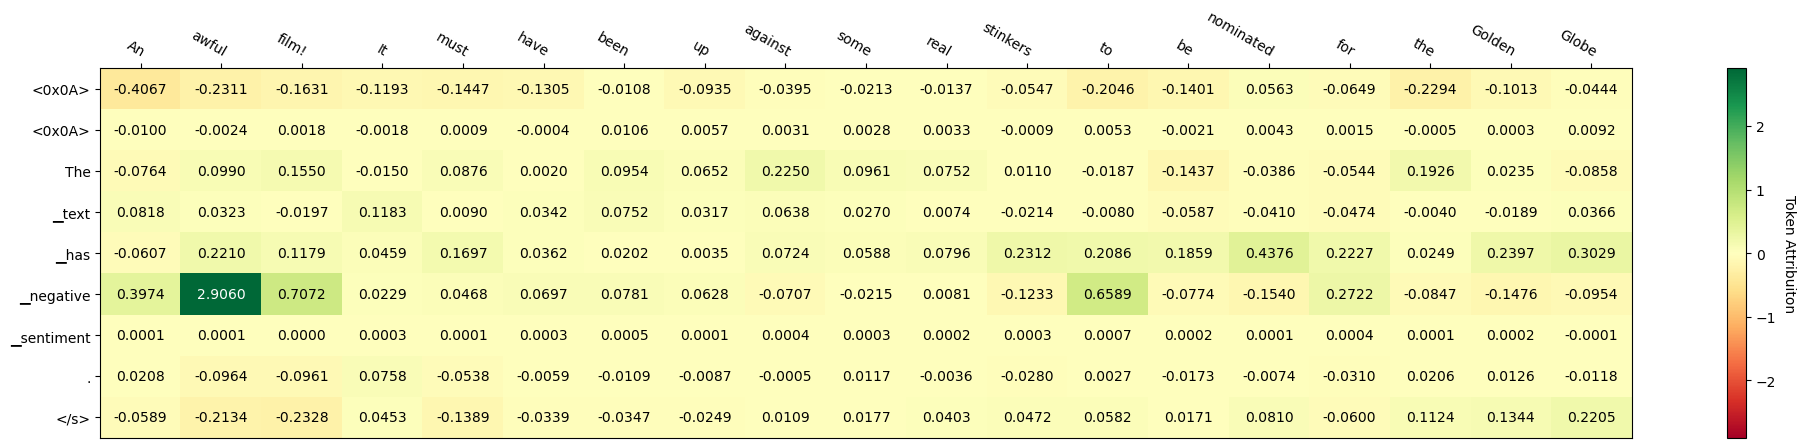

In [17]:
svs = ShapleyValueSampling(model)
llm_attr_svs = LLMAttribution(svs, tokenizer)

inp = TextTemplateInput(
    template="Your goal is to classify movie rating reviews as `positive` or `negative` sentiment. Is given text positive or negative sentiment: " \
                      "'{} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {}."  \
                      "Answer simply: 'positive' or 'negative'", 
    values=["An", "awful", "film!", "It", "must", "have", "been", "up", "against", "some", "real", "stinkers", "to", "be", "nominated", "for", "the", "Golden", "Globe"],
)
attr_res = llm_attr_fa.attribute(inp, gen_args={"max_new_tokens": 20, "do_sample": True, "temperature": 0.01}) #, n_samples = 30) #

attr_res.plot_token_attr()

<H2>Excercise 2</H2>

1. Write instruction prompts that ask LLM to classify a specific text into binary or multiple classes. Use Chain of Thought to identify most influential tokens in the input. Compare the explanations provided for chain of thought reasoning with the attribution results.

2. Experiment with different target values, baselines and input masks. 

<H1>Few shot examples - Reasoning Task<H1>

In this excercise we will use Captum for a reasoning task with few shot examples. The task is to compute mod 2 on a sum of two numbers. We provide four examples and ask LLM to solve the task based on those examples. The goal is to estimate the importance of the few shot examples in the reasoning task.

We then remove the most important example from the prompt and observe whether LLM is still able to solve the task correctly.

In [19]:
reasoning_prompt = "Here are some examples of different operations:" \
                        "(1 + 1) mod 2 = 0 , " \
                        "(2 + 1) mod 2 = 1, " \
                        "(1 + 0) mod 2 = 1, " \
                        "(0 + 0) mod 2 = 0 " \
                        " What is (2 + 0) mod 2 = ?. Think step by step."

input_tokenized = tokenizer(reasoning_prompt, return_tensors="pt").to("cuda")

print('Tokenized input: ', tokenizer.convert_ids_to_tokens(input_tokenized['input_ids'].detach().cpu().numpy()[0]))# 

with torch.no_grad():
    output_ids = model.generate(input_tokenized["input_ids"], max_new_tokens=50, temperature=0.1, do_sample=True)[0]
    output_tokenized = tokenizer.decode(output_ids, skip_special_tokens=True)
    print('LLM Response: ', output_tokenized)

Tokenized input:  ['<s>', '▁Here', '▁are', '▁some', '▁examples', '▁of', '▁different', '▁operations', ':(', '1', '▁+', '▁', '1', ')', '▁mod', '▁', '2', '▁=', '▁', '0', '▁,', '▁(', '2', '▁+', '▁', '1', ')', '▁mod', '▁', '2', '▁=', '▁', '1', ',', '▁(', '1', '▁+', '▁', '0', ')', '▁mod', '▁', '2', '▁=', '▁', '1', ',', '▁(', '0', '▁+', '▁', '0', ')', '▁mod', '▁', '2', '▁=', '▁', '0', '▁', '▁What', '▁is', '▁(', '2', '▁+', '▁', '0', ')', '▁mod', '▁', '2', '▁=', '▁?', '.', '▁Think', '▁step', '▁by', '▁step', '.']
LLM Response:  Here are some examples of different operations:(1 + 1) mod 2 = 0 , (2 + 1) mod 2 = 1, (1 + 0) mod 2 = 1, (0 + 0) mod 2 = 0  What is (2 + 0) mod 2 = ?. Think step by step.

(2 + 0) = 2

(2) mod 2 = 0


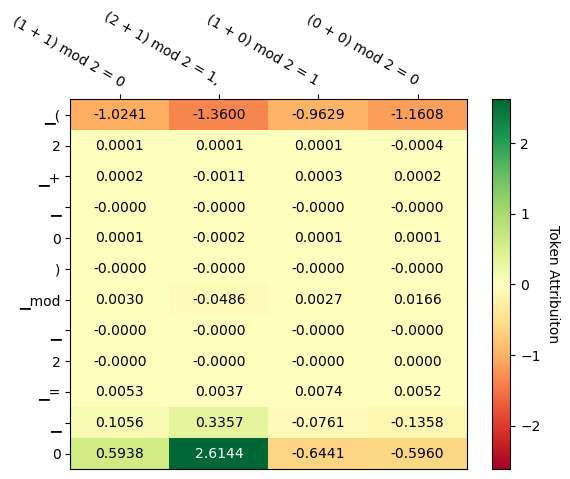

In [23]:
def prompt_fn(*examples):
    main_prompt = "What is (2 + 0) mod 2 = ?"
    subset = [elem for elem in examples if elem]
    if not subset:
        prompt = main_prompt
    else:
        prefix = "Here are some examples of different arithmetic operations:\n"
        prompt = prefix + " \n".join(subset) + "\n " + main_prompt
    return "[INST] " + prompt + "[/INST]"

input_examples = [
        "(1 + 1) mod 2 = 0",
        "(2 + 1) mod 2 = 1, ",
        "(1 + 0) mod 2 = 1 ",
        "(0 + 0) mod 2 = 0 "
]
inp = TextTemplateInput(
    prompt_fn, 
    values=input_examples,
)

sv = ShapleyValues(model) 

sv_llm_attr = LLMAttribution(sv, tokenizer)

attr_res = sv_llm_attr.attribute(inp, target="(2 + 0) mod 2 = 0")

attr_res.plot_token_attr(show=True)

Note that ` "(2 + 1) mod 2 = 1, "` is the most important out of all few-shot examples. Now, if we remove that example, the model no longer provides the correct answer. 

In [21]:
reasoning_prompt = "Here are some examples of different operations:" \
                        "(1 + 1) mod 2 = 0 , " \
                        "(1 + 0) mod 2 = 1, " \
                        "(0 + 0) mod 2 = 0 " \
                        " What is (2 + 0) mod 2 = ?. Think step by step."

input_tokenized = tokenizer(reasoning_prompt, return_tensors="pt").to("cuda")

print('Tokenized input: ', tokenizer.convert_ids_to_tokens(input_tokenized['input_ids'].detach().cpu().numpy()[0]))# 

with torch.no_grad():
    output_ids = model.generate(input_tokenized["input_ids"], max_new_tokens=50, temperature=0.1, do_sample=True)[0]
    output_tokenized = tokenizer.decode(output_ids, skip_special_tokens=True)
    print('LLM Response: ', output_tokenized)

Tokenized input:  ['<s>', '▁Here', '▁are', '▁some', '▁examples', '▁of', '▁different', '▁operations', ':(', '1', '▁+', '▁', '1', ')', '▁mod', '▁', '2', '▁=', '▁', '0', '▁,', '▁(', '1', '▁+', '▁', '0', ')', '▁mod', '▁', '2', '▁=', '▁', '1', ',', '▁(', '0', '▁+', '▁', '0', ')', '▁mod', '▁', '2', '▁=', '▁', '0', '▁', '▁What', '▁is', '▁(', '2', '▁+', '▁', '0', ')', '▁mod', '▁', '2', '▁=', '▁?', '.', '▁Think', '▁step', '▁by', '▁step', '.']
LLM Response:  Here are some examples of different operations:(1 + 1) mod 2 = 0 , (1 + 0) mod 2 = 1, (0 + 0) mod 2 = 0  What is (2 + 0) mod 2 = ?. Think step by step.

(2 + 0) = 2

2 mod 2 = ?

Answer: (2 + 0) mod 2 = 2.


<H2>Excercise 3</H2>

1. Come up with different reasoning tasks with few shot examples.
2. Experiment with different attribution algorithms to identify most important few-shot examples.
3. Try to remove those examples and observe whether the model is still able to solve the task correctly.